In [1]:
!pip install tensorflow==2.17.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
file_path = '/content/drive/MyDrive/Daset/very_last_cleaned.csv'
df = pd.read_csv(file_path)

In [5]:
df

,datetime,waterlevel,second,interpolated,waterlevel_iqr_replaced
0,2024-01-03 18:55:20,79.44,20,79.44,79.44
1,2024-01-03 18:55:21,80.80,21,80.80,80.80
2,2024-01-03 18:55:22,81.74,22,81.74,81.74
3,2024-01-03 18:55:23,NaN,23,82.30,82.30
4,2024-01-03 18:55:24,82.86,24,82.86,82.86
...,...,...,...,...,...
3676264,2024-02-15 08:06:24,92.30,24,92.30,92.30
3676265,2024-02-15 08:06:25,90.30,25,90.30,90.30
3676266,2024-02-15 08:06:26,NaN,26,89.17,89.17
3676267,2024-02-15 08:06:27,88.04,27,88.04,88.04


In [4]:
df=df.drop(columns=['waterlevel' ,	'second', 	'interpolated' ])

In [5]:
df.set_index('datetime', inplace=True)

In [6]:
# df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# Pilih baris dari tanggal 1 Januari hingga 30 Januari
data = df.loc['2024-01-03 00:00:00':'2024-01-31 23:59:59']
df_january2 = df.loc['2024-01-16 00:00:00':'2024-01-31 23:59:59']
df_feb = df.loc['2024-02-01 00:00:00':'2024-02-29 23:59:59']
df_feb_coba=df.loc['2024-02-01 00:00:00':'2024-02-05 23:59:59']
# Mengembalikan indeks datetime menjadi kolom
data.reset_index(inplace=True)
df_january2.reset_index(inplace=True)
df_feb.reset_index(inplace=True)
df_feb_coba.reset_index(inplace=True)


In [ ]:
df_january2

,datetime,waterlevel_iqr_replaced
0,2024-01-16 00:00:00,124.12
1,2024-01-16 00:00:01,127.09
2,2024-01-16 00:00:02,130.06
3,2024-01-16 00:00:03,129.25
4,2024-01-16 00:00:04,128.43
...,...,...
1382395,2024-01-31 23:59:55,106.18
1382396,2024-01-31 23:59:56,109.84
1382397,2024-01-31 23:59:57,113.04
1382398,2024-01-31 23:59:58,114.78


In [7]:
# Convert 'datetime' column to datetime objects
data['datetime'] = pd.to_datetime(data['datetime'])


<ipython-input-7-1477f8fdbcbc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['datetime'])


In [8]:
data.set_index('datetime', inplace=True)


In [9]:
df_resampled = data.resample('15T').mean()

In [10]:
data = df_resampled

In [ ]:
data

,waterlevel_iqr_replaced
datetime,
2024-01-03 18:45:00,83.200179
2024-01-03 19:00:00,82.337689
2024-01-03 19:15:00,79.920633
2024-01-03 19:30:00,80.082911
2024-01-03 19:45:00,82.149667
...,...
2024-01-31 22:45:00,112.487011
2024-01-31 23:00:00,112.565989
2024-01-31 23:15:00,111.314444


In [11]:
# Extract numerical features for scaling (excluding the datetime column)
numerical_features = data.select_dtypes(include=['number'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numerical_features)


In [ ]:
numerical_features

,waterlevel_iqr_replaced
datetime,
2024-01-03 18:45:00,83.200179
2024-01-03 19:00:00,82.337689
2024-01-03 19:15:00,79.920633
2024-01-03 19:30:00,80.082911
2024-01-03 19:45:00,82.149667
...,...
2024-01-31 22:45:00,112.487011
2024-01-31 23:00:00,112.565989
2024-01-31 23:15:00,111.314444


In [12]:
scal = pd.DataFrame({'Normalization_waterlevel': scaled_data.flatten()})

In [ ]:
scal

,Normalization_waterlevel
0,0.420126
1,0.412218
2,0.390057
3,0.391544
4,0.410494
...,...
2704,0.688647
2705,0.689371
2706,0.677896
2707,0.664141


In [ ]:
scaled_data

array([[0.42012563],
       [0.41221776],
       [0.39005661],
       ...,
       [0.67789565],
       [0.66414104],
       [0.64964397]])

In [13]:
# Fungsi untuk membuat data menjadi sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [14]:
# Panjang sequence
seq_length = 96 # 24*60/15 sequence data 1 hari

# Membuat sequences
X, y = create_sequences(scaled_data, seq_length)


In [ ]:
X.shape, y.shape

((2613, 96, 1), (2613, 1))

In [15]:
# Split the data
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]



In [16]:
import tensorflow as tf
# Create a TensorFlow dataset for efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_val.shape,y_val.shape

((1829, 96, 1), (1829, 1), (523, 96, 1), (523, 1), (261, 96, 1), (261, 1))

In [17]:
# Build the LSTM model2
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.2),
    Dense(60,activation='relu'),
    Dense(1,activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 96, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60)                  │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,881 (210.47 KB)

 Trainable params: 53,881 (210.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add callbacks
checkpoint_cb = ModelCheckpoint('best_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=500, validation_data=val_dataset,
                    callbacks=[ early_stopping_cb])

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0903 - val_loss: 0.0094
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0033 - val_loss: 9.3503e-04
Epoch 9/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0027 - val_loss: 9.9277e-04
Epoch 10/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 11/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0027 - val_loss: 5.4031e-04
Epoch 12/500
58/58 ━━━━━━━━━━━━━━━━━

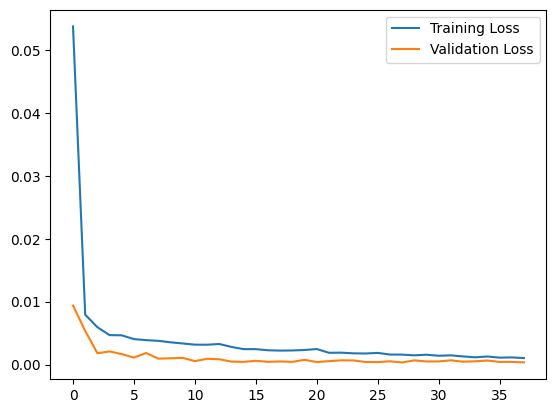

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.save('model_LSTM_Pumma_Marina.keras')

#Load Model


In [18]:
# Mengimpor library Keras
from tensorflow.keras.models import load_model

# Path ke file model di Google Drive
model_path = '/content/model_fiks_bgt2.keras'

model = load_model(model_path)


#Prediction

In [40]:
train_predictions = model.predict(X_train).flatten()


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [41]:
y_train = y_train.flatten()

In [42]:
# Inverse transform pada prediksi dan actual
train_predictions_actual = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))


train_results = pd.DataFrame({'Train Predictions': train_predictions_actual.flatten(),
                              'Actuals': y_train_actual.flatten()})
train_results


,Train Predictions,Actuals
0,79.579147,80.097522
1,79.691551,80.530233
2,80.097801,82.975733
3,81.252396,82.755833
4,82.572083,83.724578
...,...,...
1824,118.538322,118.990011
1825,116.734367,117.874789
1826,114.936569,115.455444
1827,112.864311,113.192389


In [43]:
mse_value = mean_squared_error(y_train, train_predictions)
rmse_value = np.sqrt(mse_value)
mae_value = mean_absolute_error(y_train, train_predictions)
r2_value = r2_score(y_train, train_predictions)

print(f"Mean Squared Error (MSE): {mse_value:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_value:.4f}")
print(f"Mean Absolute Error (MAE): {mae_value:.4f}")
print(f"R-squared (R²): {r2_value:.4f}")

Mean Squared Error (MSE): 0.0014
Root Mean Squared Error (RMSE): 0.0370
Mean Absolute Error (MAE): 0.0224
R-squared (R²): 0.9717


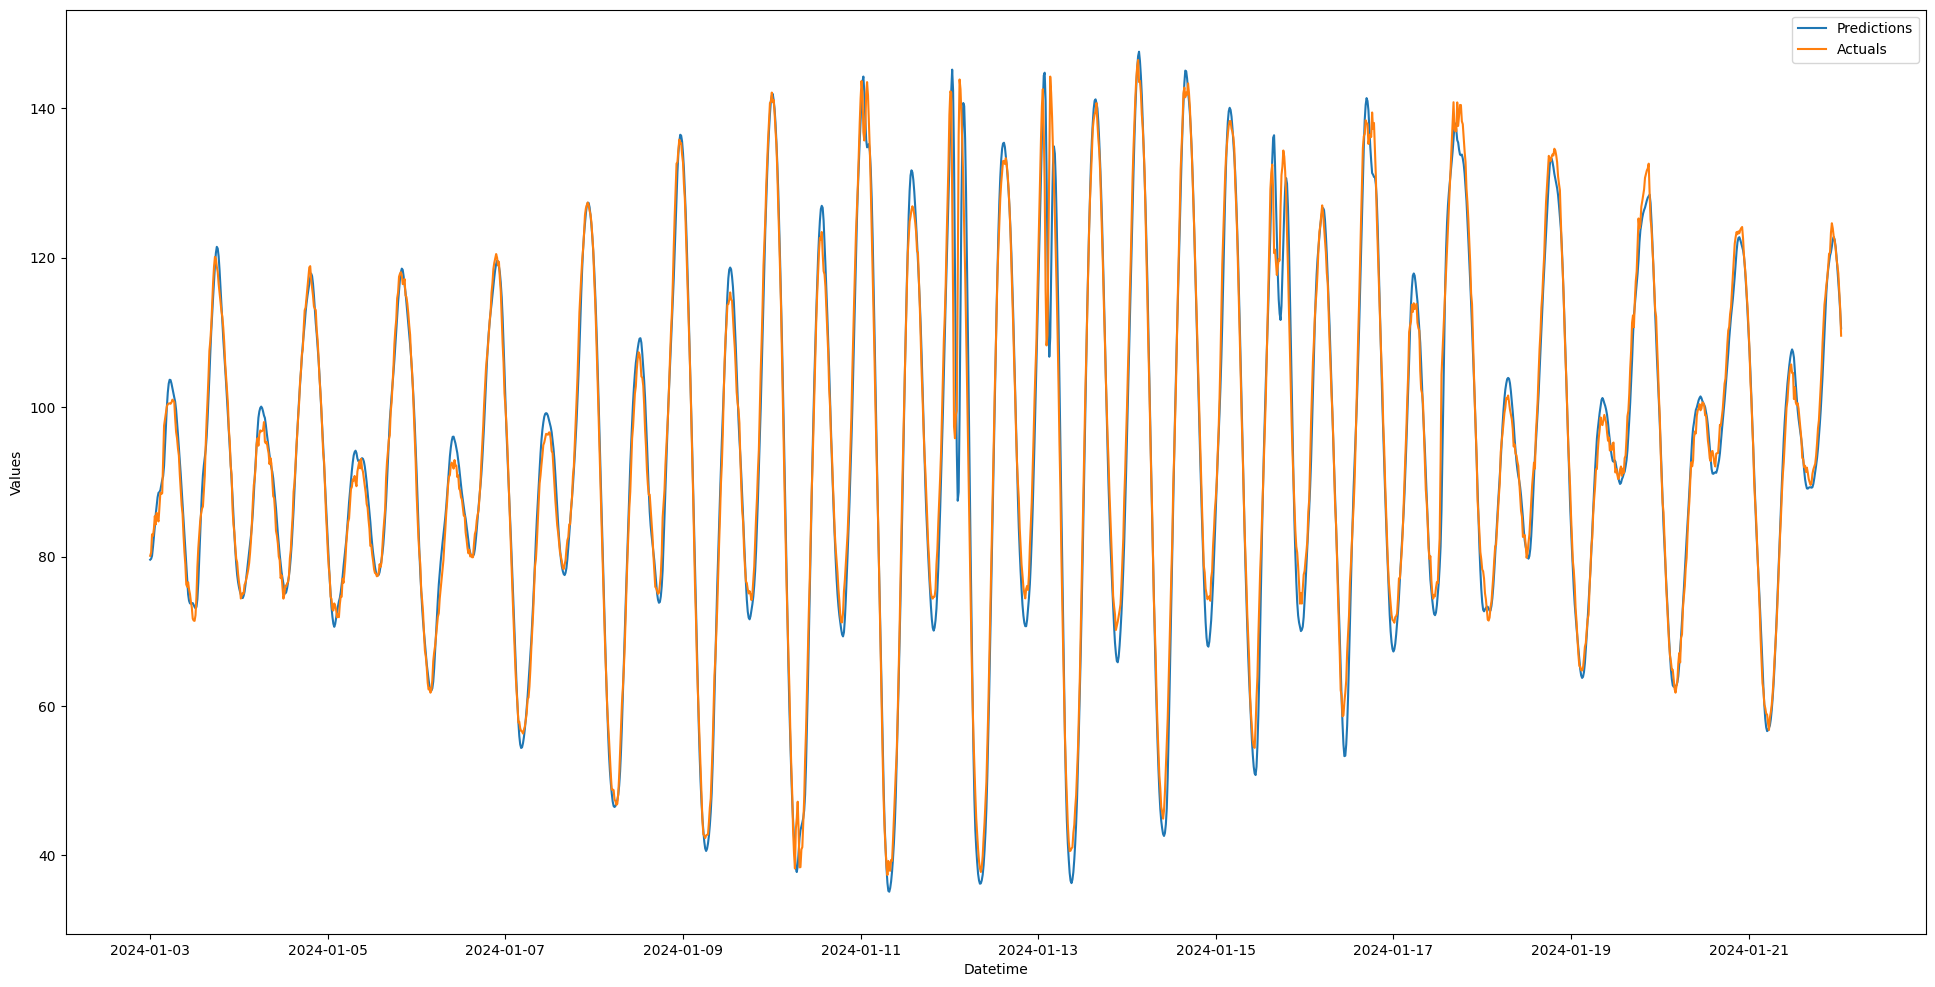

,Datetime,Predictions,Actuals
0,2024-01-03 00:00:00,79.579147,80.097522
1,2024-01-03 00:15:00,79.691551,80.530233
2,2024-01-03 00:30:00,80.097801,82.975733
3,2024-01-03 00:45:00,81.252396,82.755833
4,2024-01-03 01:00:00,82.572083,83.724578
...,...,...,...
1824,2024-01-22 00:00:00,118.538322,118.990011
1825,2024-01-22 00:15:00,116.734367,117.874789
1826,2024-01-22 00:30:00,114.936569,115.455444
1827,2024-01-22 00:45:00,112.864311,113.192389


In [ ]:
def plot_predictions_with_error1(model, X, y, datetime_series, start=0, end=2612 	 ):
    datetime_series = pd.date_range(start='2024-01-03', periods=len(X), freq='15T')
    df1 = pd.DataFrame(data={'Datetime': datetime_series, 'Predictions': train_predictions_actual.flatten(), 'Actuals': y_train_actual.flatten()})
    # Placeholder: datetime_series should be defined according to your dataset

    plt.figure(figsize=(24, 12))
    plt.plot(df1['Datetime'][start:end], df1['Predictions'][start:end], label='Predictions')
    plt.plot(df1['Datetime'][start:end], df1['Actuals'][start:end], label='Actuals')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return df1

datetime_series = pd.date_range(start='2024-01-03', periods=len(X), freq='15T')

plot_predictions_with_error1(model, X_train, y_train, datetime_series)

##val prediction


In [44]:
test_predictions = model.predict(X_val).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [45]:
y_test = y_val.flatten()

In [46]:
# Inverse transform pada prediksi dan actual
test_predictions_actual = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


test_results = pd.DataFrame({'Val Predictions': test_predictions_actual.flatten(), 'Actuals': y_test_actual.flatten()})
test_results


,Val Predictions,Actuals
0,107.673233,107.634344
1,104.756615,103.926100
2,101.549057,99.788978
3,97.939720,95.907444
4,94.041847,91.946144
...,...,...
256,84.336601,81.474144
257,80.165718,78.157811
258,76.233482,75.728444
259,72.631287,72.848844


In [47]:
mse_value_test = mean_squared_error(y_test, test_predictions)
rmse_value_test = np.sqrt(mse_value_test)
mae_value_test = mean_absolute_error(y_test, test_predictions)
r2_value = r2_score(y_test, test_predictions)

# Menampilkan hasil dengan 4 angka di belakang koma
print(f"Mean Squared Error (MSE): {mse_value_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_value_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_value_test:.4f}")
print(f"R-squared (R²): {r2_value:.4f}")

Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0199
Mean Absolute Error (MAE): 0.0164
R-squared (R²): 0.9914


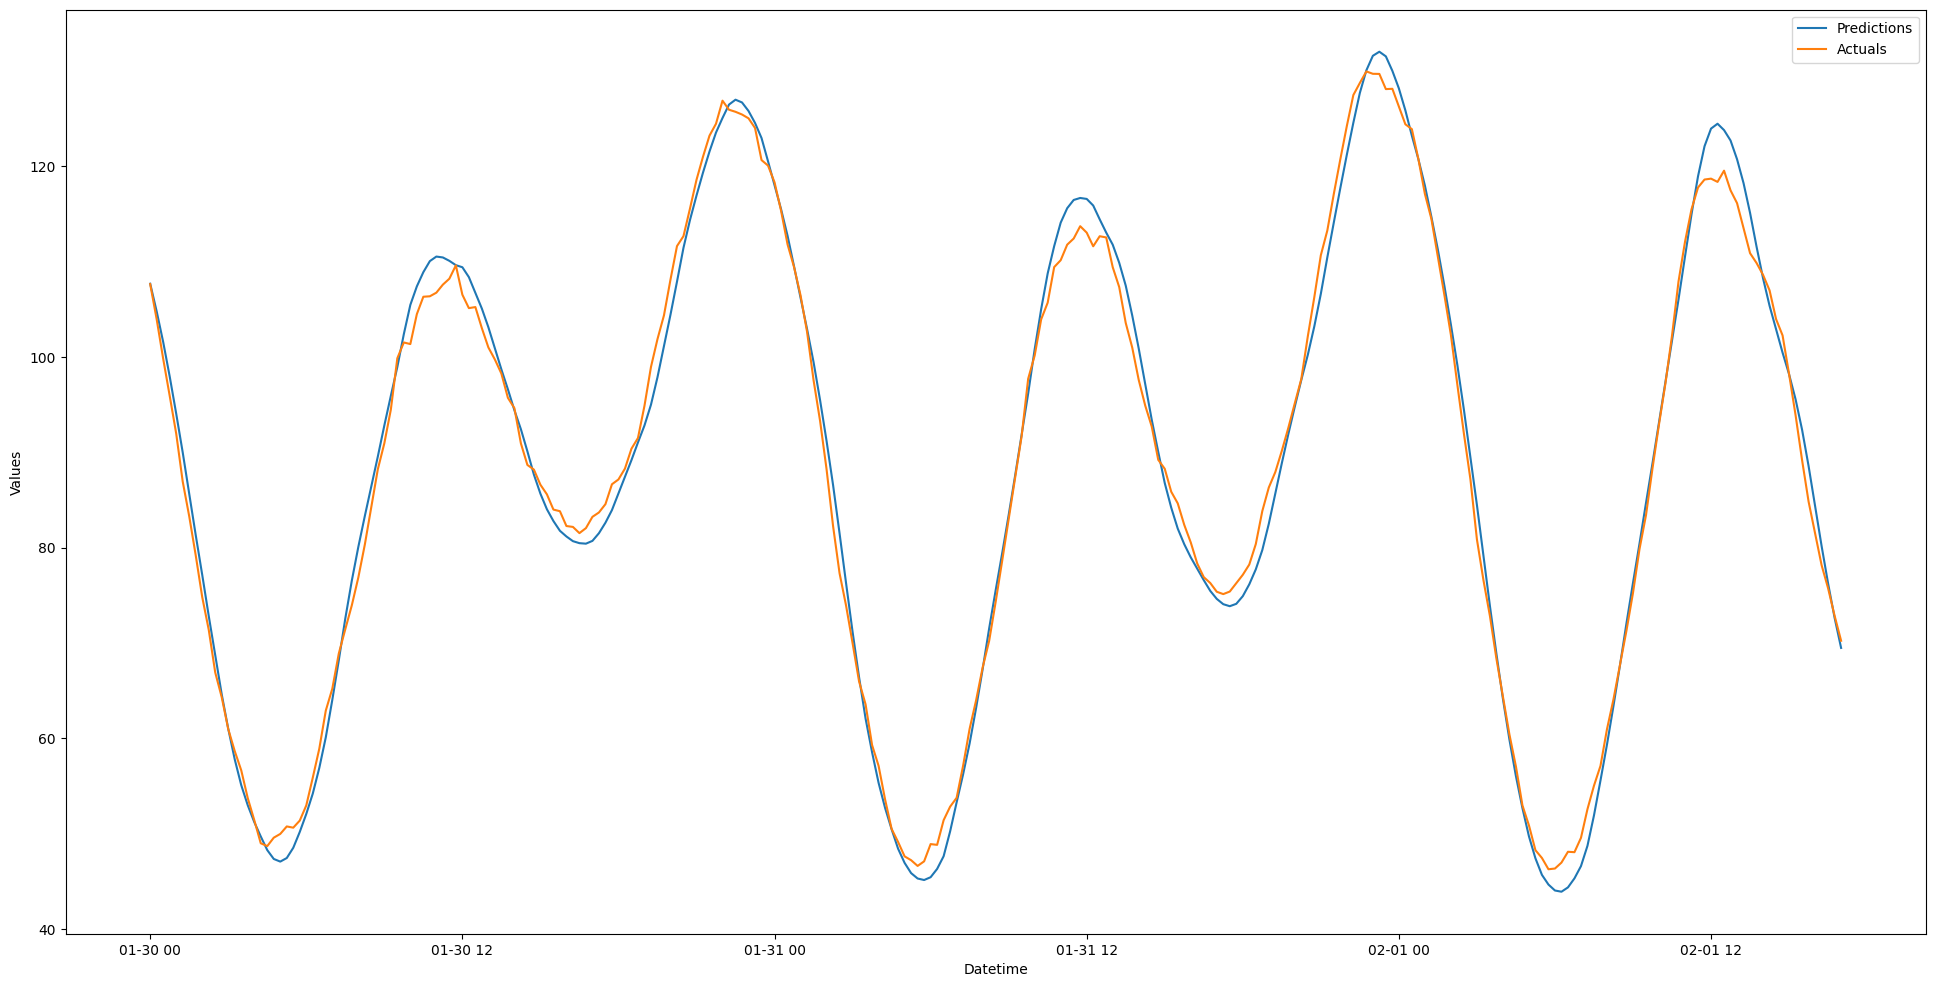

,Datetime,Predictions,Actuals
0,2024-01-30 00:00:00,107.673233,107.634344
1,2024-01-30 00:15:00,104.756615,103.926100
2,2024-01-30 00:30:00,101.549057,99.788978
3,2024-01-30 00:45:00,97.939720,95.907444
4,2024-01-30 01:00:00,94.041847,91.946144
...,...,...,...
256,2024-02-01 16:00:00,84.336601,81.474144
257,2024-02-01 16:15:00,80.165718,78.157811
258,2024-02-01 16:30:00,76.233482,75.728444
259,2024-02-01 16:45:00,72.631287,72.848844


In [ ]:
def plot_predictions_with_error2(model, X_val, y_val, datetime_series_val, start=0, end=243741 ):
    # Placeholder: datetime_series should be defined according to your dataset
    datetime_series_val = pd.date_range(start='2024-01-30', periods=len(X_val), freq='15T')

    df2 = pd.DataFrame(data={'Datetime': datetime_series_val, 'Predictions': test_predictions_actual.flatten(), 'Actuals': y_test_actual.flatten()})

    plt.figure(figsize=(24, 12))
    plt.plot(df2['Datetime'][start:end], df2['Predictions'][start:end], label='Predictions')
    plt.plot(df2['Datetime'][start:end], df2['Actuals'][start:end], label='Actuals')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return df2
datetime_series_val = pd.date_range(start='2024-01-30', periods=len(X_val), freq='15T')

plot_predictions_with_error2(model, X_val, y_val, datetime_series_val)

In [48]:
all_data_predictions = model.predict(X).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [49]:
y_all_data = y.flatten()

In [50]:
# Inverse transform pada prediksi dan actual
all_data_predictions_actual = scaler.inverse_transform(all_data_predictions.reshape(-1, 1))
y_all_data_actual = scaler.inverse_transform(y_all_data.reshape(-1, 1))


predict_all_results = pd.DataFrame({'Test Predictions': all_data_predictions_actual.flatten(),
                                    'Actuals': y_all_data_actual.flatten()})
predict_all_results


,Test Predictions,Actuals
0,79.579147,80.097522
1,79.691551,80.530233
2,80.097801,82.975733
3,81.252396,82.755833
4,82.572083,83.724578
...,...,...
2608,116.121384,112.487011
2609,114.521431,112.565989
2610,112.857918,111.314444
2611,111.044083,109.814267


In [51]:
mse_value_all = mean_squared_error(y_all_data, all_data_predictions)
rmse_value_all = np.sqrt(mse_value_all)
mae_value_all = mean_absolute_error(y_all_data, all_data_predictions)
r2_value = r2_score(y_all_data, all_data_predictions)

# Menampilkan hasil dengan 4 angka di belakang koma
print(f"Mean Squared Error (MSE) Test: {mse_value_all:.4f}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_value_all:.4f}")
print(f"Mean Absolute Error (MAE) test: {mae_value_all:.4f}")
print(f"R-squared (R²): {r2_value:.4f}")

Mean Squared Error (MSE) Test: 0.0011
Root Mean Squared Error (RMSE) Test: 0.0338
Mean Absolute Error (MAE) test: 0.0216
R-squared (R²): 0.9770


In [53]:
def plot_predictions_with_error3(model, X, y, datetime_series, start=0, end=2437419 ):
    # Placeholder: datetime_series should be defined according to your dataset
    datetime_series_all = pd.date_range(start='2024-01-01', periods=len(X), freq='s')

    df3 = pd.DataFrame(data={'Datetime': datetime_series_all, 'All Predictions': all_data_predictions_actual.flatten(), 'Actuals': y_all_data_actual.flatten()})

    plt.figure(figsize=(24, 12))
    plt.plot(df3['Datetime'][start:end], df3['All Predictions'][start:end], label='Predictions')
    plt.plot(df3['Datetime'][start:end], df3['Actuals'][start:end], label='Actuals')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return df3


plot_predictions_with_error3(model, X_test, y_test, datetime_series)

NameError: name 'datetime_series' is not defined

#Predict from New data

In [53]:
df_feb

,datetime,waterlevel_iqr_replaced
0,2024-02-01 00:00:00,114.36
1,2024-02-01 00:00:01,113.69
2,2024-02-01 00:00:02,113.02
3,2024-02-01 00:00:03,112.34
4,2024-02-01 00:00:04,111.67
...,...,...
1238784,2024-02-15 08:06:24,92.30
1238785,2024-02-15 08:06:25,90.30
1238786,2024-02-15 08:06:26,89.17
1238787,2024-02-15 08:06:27,88.04


#coba


#3 Hari

In [41]:
df_january2.reset_index('datetime',inplace=True)

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# Memuat dataset
df = df_january2
# Memastikan indeks dalam format datetime
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# Mengubah interval data menjadi 15 menit dengan nilai rata-rata
df_resampled = df.resample('15T').mean()
# Menampilkan 15 data terakhir dari dataset yang di-resample
print("15 data terakhir dari dataset yang di-resample:")
print(df_resampled.tail(15))
# Pastikan df hanya data numerik (drop datetime jika ada)
numerical_df = df_resampled.select_dtypes(include=[np.number])
# Mengambil 96 data terakhir (karena 15 menit * 96 = 1 hari)
last_96_data = numerical_df.values[-96:]
# Scaling data
scaler = MinMaxScaler()  # Pastikan menggunakan scaler yang sama saat pelatihan
scaled_last_96_data = scaler.fit_transform(numerical_df)  # Fit transform seluruh numerical_df
scaled_last_96_data = scaled_last_96_data[-96:]  # Pilih 96 data terakhir

# Membuat sequence untuk prediksi
X_predict = np.array([scaled_last_96_data])
# Inisialisasi daftar untuk menyimpan prediksi
future_predictions = []
# Jumlah prediksi masa depan untuk 3 hari ke depan dengan interval 15 menit
num_predictions = 3 * 24 * 4
for _ in range(num_predictions):
    # Prediksi nilai berikutnya
    next_pred_scaled = model.predict(X_predict)
    # Denormalisasi nilai prediksi
    next_pred = scaler.inverse_transform(next_pred_scaled)
    # Tambahkan nilai prediksi ke future_predictions
    future_predictions.append(next_pred[0])
    # Update input sequence dengan nilai prediksi
    X_predict = np.append(X_predict[:, 1:, :], [[next_pred_scaled[0]]], axis=1)

# Konversi future predictions ke DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=numerical_df.columns)
# Generate future datetime values based on the original datetime index frequency
last_date = df_resampled.index[-1]  # Ambil tanggal terakhir di data asli
future_dates = pd.date_range(start=last_date, periods=num_predictions + 1, freq='15T')[1:]
# Tambahkan indeks datetime ke DataFrame prediksi
future_predictions_df.index = future_dates
# Gabungkan future predictions dengan data asli
df_extended = pd.concat([df_resampled, future_predictions_df], ignore_index=False)
# Print future predictions
print(future_predictions_df)



15 data terakhir dari dataset yang di-resample:
                     waterlevel_iqr_replaced
datetime                                    
2024-01-31 20:15:00                99.869744
2024-01-31 20:30:00               102.812089
2024-01-31 20:45:00               107.163878
2024-01-31 21:00:00               109.539878
2024-01-31 21:15:00               111.599811
2024-01-31 21:30:00               113.624222
2024-01-31 21:45:00               113.444822
2024-01-31 22:00:00               113.528889
2024-01-31 22:15:00               113.532444
2024-01-31 22:30:00               114.318911
2024-01-31 22:45:00               112.487011
2024-01-31 23:00:00               112.565989
2024-01-31 23:15:00               111.314444
2024-01-31 23:30:00               109.814267
2024-01-31 23:45:00               108.233111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/st

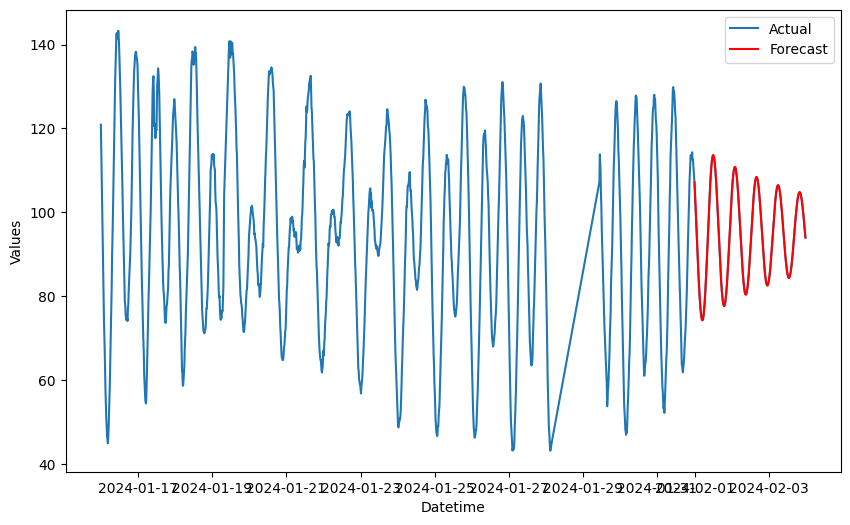

In [56]:
# Plot hasil prediksi (opsional)
plt.figure(figsize=(10, 6))
plt.plot(df_extended.index, df_extended[numerical_df.columns[0]], label='Actual')
plt.plot(future_predictions_df.index, future_predictions_df[numerical_df.columns[0]], label='Forecast', color='red')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
future_predictions_df

,waterlevel_iqr_replaced
2024-02-06 00:00:00,74.953430
2024-02-06 00:15:00,76.975502
2024-02-06 00:30:00,79.190910
2024-02-06 00:45:00,81.579376
2024-02-06 01:00:00,84.080658
...,...
2024-02-08 22:45:00,79.144226
2024-02-08 23:00:00,79.700378
2024-02-08 23:15:00,80.378799
2024-02-08 23:30:00,81.171364


In [46]:
df_feb.reset_index('datetime', inplace=True)

In [47]:
df = df_feb

# Convert the timestamp column to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the timestamp column as the index
df.set_index('datetime', inplace=True)

# Resample the DataFrame to get values every 15 minutes
df_15min = df.resample('15T').first()

# Filter the DataFrame for the date range from 1st to 7th
start_date = '2024-02-01 00:00:00'
end_date = '2024-02-03 23:45:00'
df_15min_filtered = df_15min.loc[start_date:end_date]

In [21]:
df_15min_filtered

,waterlevel_iqr_replaced
datetime,
2024-02-01 00:00:00,114.36
2024-02-01 00:15:00,99.62
2024-02-01 00:30:00,103.72
2024-02-01 00:45:00,94.94
2024-02-01 01:00:00,91.32
...,...
2024-02-03 22:45:00,89.88
2024-02-03 23:00:00,92.70
2024-02-03 23:15:00,90.54


In [48]:
import pandas as pd

# Ambil nilai pada kolom 'waterlevel_iqr_replaced' dari kedua data frame
future_predictions_waterlevel = future_predictions_df['waterlevel_iqr_replaced']
df_15min_waterlevel = df_15min_filtered['waterlevel_iqr_replaced']

# Buatkan data frame baru dengan nama df_uji_forecast
df_uji_forecast = pd.DataFrame({
    'waterlevel_Prediction': future_predictions_waterlevel,
    'waterlevel_Actual': df_15min_waterlevel
})


In [49]:
df_uji_forecast

,waterlevel_Prediction,waterlevel_Actual
2024-02-01 00:00:00,107.117249,114.36
2024-02-01 00:15:00,105.106529,99.62
2024-02-01 00:30:00,103.047714,103.72
2024-02-01 00:45:00,100.916626,94.94
2024-02-01 01:00:00,98.723587,91.32
...,...,...
2024-02-03 22:45:00,98.192101,89.88
2024-02-03 23:00:00,97.162773,92.70
2024-02-03 23:15:00,96.113129,90.54
2024-02-03 23:30:00,95.056641,99.46


In [50]:
# Membuat instance dari MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Mengaplikasikan skala pada data frame
df_uji_forecast[['waterlevel_Prediction',
                 'waterlevel_Actual']] = scaler.fit_transform(df_uji_forecast[['waterlevel_Prediction',
                 'waterlevel_Actual']])

In [52]:
def evaluate_metrics(df):
    # MSE (Mean Squared Error)
    mse = np.mean((df['waterlevel_Prediction'] - df['waterlevel_Actual']) ** 2)

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(df['waterlevel_Prediction'] - df['waterlevel_Actual']))

    #R2 score
    r2_valuee = r2_score(df['waterlevel_Actual'], df['waterlevel_Prediction'])

    return mse, rmse, mae, r2_value


# Evaluasi nilai dengan menggunakan matrix MSE, RMSE, MAE, dan MAPE
mse, rmse, mae, r2_value = evaluate_metrics(df_uji_forecast)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-Score:", r2_value)


MSE: 0.13131431396124882
RMSE: 0.36237316948312936
MAE: 0.2972351225908916
R-Score: 0.6379112917070346


#7 Hari

In [ ]:
df_january2.reset_index('datetime',inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Memuat dataset
df = df_january2
# Memastikan indeks dalam format datetime
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# Mengubah interval data menjadi 15 menit dengan nilai rata-rata
df_resampled = df.resample('15T').mean()
# Menampilkan 15 data terakhir dari dataset yang di-resample
print("15 data terakhir dari dataset yang di-resample:")
print(df_resampled.tail(15))
# Pastikan df hanya data numerik (drop datetime jika ada)
numerical_df = df_resampled.select_dtypes(include=[np.number])
# Mengambil 96 data terakhir (karena 15 menit * 96 = 1 hari)
last_96_data = numerical_df.values[-96:]
# Scaling data
scaler = MinMaxScaler()  # Pastikan menggunakan scaler yang sama saat pelatihan
scaled_last_96_data = scaler.fit_transform(numerical_df)  # Fit transform seluruh numerical_df
scaled_last_96_data = scaled_last_96_data[-96:]  # Pilih 96 data terakhir

# Membuat sequence untuk prediksi
X_predict = np.array([scaled_last_96_data])
# Inisialisasi daftar untuk menyimpan prediksi
future_predictions = []
# Jumlah prediksi masa depan untuk 3 hari ke depan dengan interval 15 menit
num_predictions = 7 * 24 * 4
for _ in range(num_predictions):
    # Prediksi nilai berikutnya
    next_pred_scaled = model.predict(X_predict)
    # Denormalisasi nilai prediksi
    next_pred = scaler.inverse_transform(next_pred_scaled)
    # Tambahkan nilai prediksi ke future_predictions
    future_predictions.append(next_pred[0])
    # Update input sequence dengan nilai prediksi
    X_predict = np.append(X_predict[:, 1:, :], [[next_pred_scaled[0]]], axis=1)

# Konversi future predictions ke DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=numerical_df.columns)
# Generate future datetime values based on the original datetime index frequency
last_date = df_resampled.index[-1]  # Ambil tanggal terakhir di data asli
future_dates = pd.date_range(start=last_date, periods=num_predictions + 1, freq='15T')[1:]
# Tambahkan indeks datetime ke DataFrame prediksi
future_predictions_df.index = future_dates
# Gabungkan future predictions dengan data asli
df_extended = pd.concat([df_resampled, future_predictions_df], ignore_index=False)
# Print future predictions
print(future_predictions_df)



15 data terakhir dari dataset yang di-resample:
                     waterlevel_iqr_replaced
datetime                                    
2024-01-31 20:15:00                99.869744
2024-01-31 20:30:00               102.812089
2024-01-31 20:45:00               107.163878
2024-01-31 21:00:00               109.539878
2024-01-31 21:15:00               111.599811
2024-01-31 21:30:00               113.624222
2024-01-31 21:45:00               113.444822
2024-01-31 22:00:00               113.528889
2024-01-31 22:15:00               113.532444
2024-01-31 22:30:00               114.318911
2024-01-31 22:45:00               112.487011
2024-01-31 23:00:00               112.565989
2024-01-31 23:15:00               111.314444
2024-01-31 23:30:00               109.814267
2024-01-31 23:45:00               108.233111
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

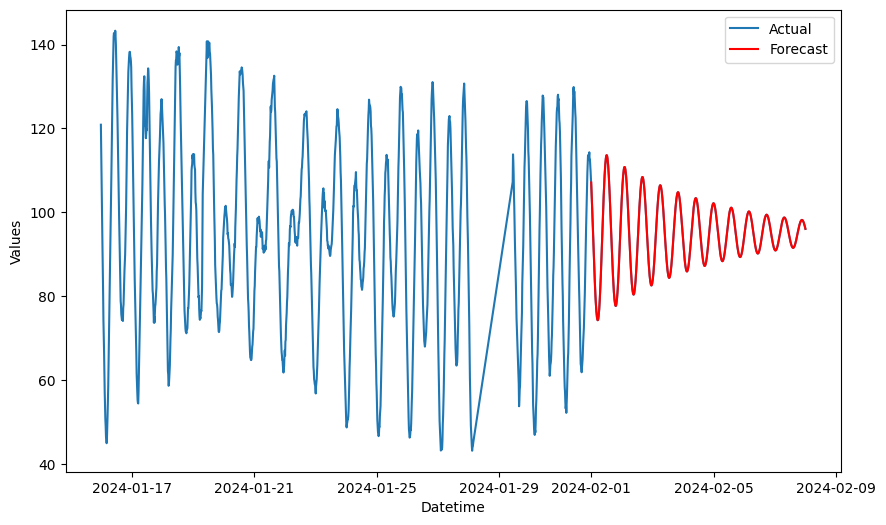

In [ ]:
# Plot hasil prediksi (opsional)
plt.figure(figsize=(10, 6))
plt.plot(df_extended.index, df_extended[numerical_df.columns[0]], label='Actual')
plt.plot(future_predictions_df.index, future_predictions_df[numerical_df.columns[0]], label='Forecast', color='red')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
df_feb.reset_index('datetime',inplace=True)

In [ ]:
df = df_feb

# Convert the timestamp column to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the timestamp column as the index
df.set_index('datetime', inplace=True)

# Resample the DataFrame to get values every 15 minutes
df_15min = df.resample('15T').first()

# Filter the DataFrame for the date range from 1st to 7th
start_date = '2024-02-01 00:00:00'
end_date = '2024-02-07 23:45:00'
df_15min_filtered = df_15min.loc[start_date:end_date]

In [ ]:
import pandas as pd

# Ambil nilai pada kolom 'waterlevel_iqr_replaced' dari kedua data frame
future_predictions_waterlevel = future_predictions_df['waterlevel_iqr_replaced']
df_15min_waterlevel = df_15min_filtered['waterlevel_iqr_replaced']

# Buatkan data frame baru dengan nama df_uji_forecast
df_uji_forecast = pd.DataFrame({
    'waterlevel_Prediction': future_predictions_waterlevel,
    'waterlevel_Actual': df_15min_waterlevel
})


In [ ]:
df_uji_forecast

,waterlevel_Prediction,waterlevel_Actual
2024-02-01 00:00:00,107.117249,114.36
2024-02-01 00:15:00,105.106529,99.62
2024-02-01 00:30:00,103.047714,103.72
2024-02-01 00:45:00,100.916626,94.94
2024-02-01 01:00:00,98.723587,91.32
...,...,...
2024-02-07 22:45:00,97.243958,54.80
2024-02-07 23:00:00,96.977966,51.94
2024-02-07 23:15:00,96.688141,46.32
2024-02-07 23:30:00,96.378365,46.74


In [ ]:
# Membuat instance dari MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Mengaplikasikan skala pada data frame
df_uji_forecast[['waterlevel_Prediction',
                 'waterlevel_Actual']] = scaler.fit_transform(df_uji_forecast[['waterlevel_Prediction',
                 'waterlevel_Actual']])

In [ ]:
def evaluate_metrics(df_uji_forecast):
    # MSE (Mean Squared Error)
    mse = np.mean((df_uji_forecast['waterlevel_Prediction'] - df_uji_forecast['waterlevel_Actual']) ** 2)

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(df_uji_forecast['waterlevel_Prediction'] - df_uji_forecast['waterlevel_Actual']))


    return mse, rmse, mae

# Evaluasi nilai dengan menggunakan matrix MSE, RMSE, MAE, dan MAPE
mse, rmse, mae = evaluate_metrics(df_uji_forecast)

print("MSE 7 hari:", mse)
print("RMSE 7 hari:", rmse)
print("MAE: 7 hari", mae)

MSE 7 hari: 0.07854108557717382
RMSE 7 hari: 0.280251825287854
MAE: 7 hari 0.2255495877639943


#14 hari